In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


LABEL = "160_labelled"

# initializing lemmatizer
stemmer = SnowballStemmer("english")
wordnet_lemmatizer = WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(wordnet_lemmatizer.lemmatize)
 
# ===========helper methods ========================================
def remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)

def stop_words_list():
    """
        A stop list specific to the observed timelines composed of noisy words
        This list would change for different set of timelines
    """
    stop_words = ['bc', 'http', 'https', 'co', 'rt', 'one', 'us', 'new',
              'lol', 'may', 'get', 'want', 'like', 'love', 'no', 'thank', 'would', 'thanks',
              'via', 'today', 'gt', 'great', 'watch', 'watched', 'season',
              '00p']

    stoplist  = set( nltk.corpus.stopwords.words("english") + stop_words)
    return stoplist

def remove_urls(text):
    text = re.sub(r"(?:\@|http?\://)\S+", "", text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

def tokenize(text):
    """
    helper function to readTweets() removes url and tokenizes text
    :param text
    """
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = re.sub(r"""[\'\"]""",'', text)
    regexps = (
        r"""(?:[\w_]+)""",                          # regular word
        r"""(?:[a-z][a-z'\-_]+[a-z])"""             # word with an apostrophe or a dash
    )
    tokens_regexp = re.compile(r"""(%s)""" % "|".join(regexps),
                               re.VERBOSE | re.I | re.UNICODE)
    return tokens_regexp.findall(text)

def replace_acronym(tokens, slang_dict):
    new_tokens = []
    for token in tokens:
        if token in slang_dict:
            new_tokens.extend(slang_dict[token].split())
        else:
            new_tokens.append(token)
    return new_tokens

def tokenize_and_lemmatize(text, slang_dict, stop_words):
    # get the tokens, lowercase - replace acronym
    lowered = [item.lower() for item in tokenize(text)]
    tokens = replace_acronym(lowered, slang_dict)

    
    tokens_pos = pos_tag(tokens)
    words = []
    for token in tokens_pos:
        pos = get_wordnet_pos(token[1])
        # if verb, noun, adj or adverb include them after lemmatization
        if pos is not None and token[0] not in stop_words:
            try:
                tok = lemmatize(token[0], pos)
                words.append(tok)
            except UnicodeDecodeError:
                pass
    # print words
    return words

def read_in_dict(filename):
    dict = {}
    with open(filename) as f:
        for line in f.readlines():
            parts = line.partition(":")
            dict[parts[0].strip()] = parts[2].strip()
    return dict

In [2]:
test_df = pd.read_csv("data/cluster_test.csv",  low_memory=False)

<hr>
### <u>About the Dataset </u>
Reading the data set, This dataset has 160 tweets , with labels 
<hr>

In [3]:
print(test_df[:5])

   Unnamed: 0      label                                              tweet  \
0           0  #politics  Delano Hotel Sold to Company That Runs SLS, Ra...   
1           1  #politics  Who Promoted #PrivateRyan? | RealClearPolitics...   
2           2  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
3           3  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
4           4  #politics  Lead testing inconsistent in Washington school...   

                 user  
0  730076605708537856  
1  730076585378893824  
2  730076554542391296  
3  730076553850269696  
4  730076487123017728  


In [4]:
# convert the pandas series (tweet text) to numpy array
text = test_df.iloc[:, 2]
tweet_text = np.array(text)

Take the column of tweet text and convert to numpy array, for use in tfidf

In [5]:
def get_tfidf_model(texts, stop_words= None, slang_dict=None):
    stop_words = stop_words_list()
    vectorizer = TfidfVectorizer(tokenizer=lambda text: tokenize_and_lemmatize(text, slang_dict, stop_words),
                                 stop_words=None,
                                 max_df=0.9,
                                 min_df=3,
                                 lowercase=True,
                                 decode_error='ignore',
                                 )

    #print ("vocabulary_: ", vectorizer.vocabulary_)
    
    tfidf_model = vectorizer.fit_transform(texts)
    return tfidf_model, vectorizer
    

slang_dict = read_in_dict("data/out_slang_map.csv")
tfidf_model, vectorizer = get_tfidf_model(tweet_text[:1000], stop_words_list(), slang_dict)

print(tfidf_model.shape)

(160, 90)


In [6]:
# gmm maximisation
clf = mixture.GMM(n_components=10, n_iter=500, n_init=10)
print (clf)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=10, n_iter=500, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


Aikaki Information Criteria(AIC) and the Bayesian Information Criterion(BIC)

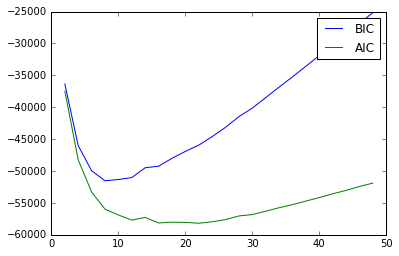

In [7]:
n_estimators = np.arange(2,50, step=2)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

n             bic              aic 
2             -36361              -37471
3             -40044              -41711
4             -45699              -47922
5             -48773              -51553
6             -50256              -53593
7             -51168              -55061
8             -51352              -55801
9             -51365              -56371
10             -51776              -57339
11             -51140              -57259


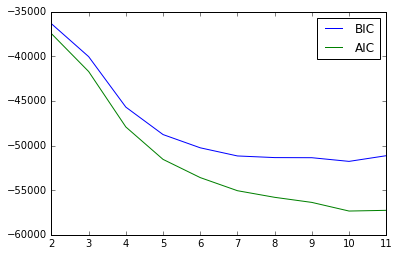

In [8]:
n_estimators = np.arange(2,12, step=1)
tfarray = tfidf_model.toarray()
clfs = [mixture.GMM(n, n_iter=500).fit(tfarray) for n in n_estimators]
bics = [clf.bic(tfarray) for clf in clfs]
aics = [clf.aic(tfarray) for clf in clfs]

plt.plot(n_estimators, bics, label= 'BIC')
plt.plot(n_estimators, aics, label= 'AIC')
plt.legend()

i = 1
print("n             bic              aic ")
for x, y in zip(bics, aics):
    i += 1
    print("%d             %d              %d" % (i, x, y) )

In [9]:
# Log probabilities of each data point in tfarray
clf = mixture.GMM(n_components=9, n_iter=500).fit(tfarray)
# print( clf.score(tfarray))


<hr>
<b> GMM EM gives 9 clusters </b>


In [10]:
# true labels
t_labels = test_df.iloc[:, 1]

# run k means :
clusters = 9
km_model = KMeans(n_clusters=clusters)
cluster = km_model.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

print(type(cluster))
test_df.loc[:, 'cluster'] = pd.Series(cluster)
print(test_df[:5])
test_df.to_csv("results/kmeans_" + LABEL + ".csv")

Silhouette score                   : 0.236236
Adjusted Rand Score                : 0.891898
Adjusted Mutual Information Score  : 0.900920
Normalized Mutual Information Score: 0.923915
Normalized Mutual Information Score: 0.923915
Homogeniety Score                  : 0.937827
Completeness Score                 : 0.910210
<class 'numpy.ndarray'>
   Unnamed: 0      label                                              tweet  \
0           0  #politics  Delano Hotel Sold to Company That Runs SLS, Ra...   
1           1  #politics  Who Promoted #PrivateRyan? | RealClearPolitics...   
2           2  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
3           3  #politics  #liberty #freedom #gop #democrat #trump #hilla...   
4           4  #politics  Lead testing inconsistent in Washington school...   

                 user  cluster  
0  730076605708537856        8  
1  730076585378893824        8  
2  730076554542391296        8  
3  730076553850269696        8  
4  73007648712

In [11]:
# top 10 words in a cluster
order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: sport uk record terminal open roger awesome need news tour
Cluster 1: food recipe roger deal tonight enjoy foodporn yum foodie memoir
Cluster 2: tv roger movie series life game free show top work
Cluster 3: fashion style womens top amp photo show kiss life terminal
Cluster 4: music play terminal problem roger release kiss join try entertainment
Cluster 5: art roger inspire say work f1 slipstream lewishamilton form hamilton
Cluster 6: aaa start arena fukuoka leap leapover tour live music roger
Cluster 7: news game gamingnews mobile phone apple lovescroll todayng release roger
Cluster 8: politics trump cruz enter leave white door race house open


In [12]:
# run Birch:
birch = Birch(n_clusters=clusters)
cluster = birch.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.178664
Adjusted Rand Score                : 0.571966
Adjusted Mutual Information Score  : 0.682479
Normalized Mutual Information Score: 0.716375
Normalized Mutual Information Score: 0.716375
Homogeniety Score                  : 0.713454
Completeness Score                 : 0.719308


In [13]:
# run SpectralClustering
spectral = SpectralClustering(n_clusters=clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
cluster = spectral.fit_predict(tfidf_model)

# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))

Silhouette score                   : 0.230888
Adjusted Rand Score                : 0.893085
Adjusted Mutual Information Score  : 0.904963
Normalized Mutual Information Score: 0.930468
Normalized Mutual Information Score: 0.930468
Homogeniety Score                  : 0.947349
Completeness Score                 : 0.913887


In [14]:
# db scan
dbscan = DBSCAN(eps=.2)
cluster = dbscan.fit_predict(tfidf_model)
print("clusters by DBSCAN: %d" % len(set(cluster)))
# result analysis :
print("Silhouette score                   : %f" % silhouette_score(tfidf_model, cluster, sample_size=2000))
print("Adjusted Rand Score                : %f" % metrics.adjusted_rand_score(t_labels, cluster))
print("Adjusted Mutual Information Score  : %f" % metrics.adjusted_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Normalized Mutual Information Score: %f" % metrics.normalized_mutual_info_score(t_labels, cluster))
print("Homogeniety Score                  : %f" % metrics.homogeneity_score(t_labels, cluster))
print("Completeness Score                 : %f" % metrics.completeness_score(t_labels, cluster))


clusters by DBSCAN: 4
Silhouette score                   : 0.049267
Adjusted Rand Score                : 0.009247
Adjusted Mutual Information Score  : 0.063933
Normalized Mutual Information Score: 0.219022
Normalized Mutual Information Score: 0.219022
Homogeniety Score                  : 0.097742
Completeness Score                 : 0.490791
